<a href="https://colab.research.google.com/github/FedericaBellini22/CVProject-2024/blob/main/mobilenet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Extract the tar.gz file
!tar -xvzf '/content/drive/My Drive/PKLot.tar.gz' -C /content/pklot/

Output streaming troncato alle ultime 5000 righe.
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_18_09_45#088.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_09_06_05#086.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-31/Occupied/2012-10-31_14_33_21#092.jpg
PKLot/PKLotSegmented/UFPR04/Rainy/2013-01-21/Occupied/2013-01-21_08_35_04#011.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-10-16/Empty/2012-10-16_06_26_44#050.jpg
PKLot/PKLotSegmented/PUC/Cloudy/2012-09-28/Occupied/2012-09-28_11_06_11#047.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-17/Occupied/2012-09-17_10_59_02#100.jpg
PKLot/PKLotSegmented/UFPR05/Sunny/2013-03-10/Empty/2013-03-10_17_35_13#027.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-10-27/Empty/2012-10-27_12_15_53#018.jpg
PKLot/PKLotSegmented/PUC/Rainy/2012-09-21/Occupied/2012-09-21_11_45_24#077.jpg
PKLot/PKLotSegmented/PUC/Sunny/2012-09-20/Occupied/2012-09-20_17_34_43#052.jpg
PKLot/PKLotSegmented/UFPR05/Cloudy/2013-03-17/Empty/2013-03-17_15_20_10#033.jpg


In [ ]:
import os
import shutil
import random

# Define the base dataset directory
dataset_base_dir = '/content/pklot/PKLot/'  # The main directory after unzipping
segmented_base_dir = '/content/pklot/PKLotSegmented/'  # Include the segmented images if needed

# Define directories for organized dataset
train_dir = '/content/pklot/train'
val_dir = '/content/pklot/validation'
test_dir = '/content/pklot/test'

# Create directories for train, validation, and test sets
for directory in [train_dir, val_dir, test_dir]:
    for label in ['empty', 'occupied']:
        os.makedirs(os.path.join(directory, label), exist_ok=True)

# Split ratios
train_split = 0.7
val_split = 0.2
test_split = 0.1

# Collect image paths from all subdirectories
image_paths = []

# Walk through all directories under PKLot and PKLotSegmented
for base_dir in [dataset_base_dir, segmented_base_dir]:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))

# Shuffle the image paths to ensure random distribution
random.shuffle(image_paths)

# Function to move files based on the labels
def move_images(image_paths, start_idx, end_idx, dest_dir):
    for img_path in image_paths[start_idx:end_idx]:
        if 'Empty' in img_path or 'empty' in img_path:  # Assuming filenames or directories indicate label
            shutil.move(img_path, os.path.join(dest_dir, 'empty', os.path.basename(img_path)))
        elif 'Occupied' in img_path or 'occupied' in img_path:
            shutil.move(img_path, os.path.join(dest_dir, 'occupied', os.path.basename(img_path)))

# Calculate the indices for splitting the dataset
total_images = len(image_paths)
train_idx = int(train_split * total_images)
val_idx = int((train_split + val_split) * total_images)

# Move images to the corresponding train, validation, and test directories
move_images(image_paths, 0, train_idx, train_dir)
move_images(image_paths, train_idx, val_idx, val_dir)
move_images(image_paths, val_idx, total_images, test_dir)

print(f"Total images: {total_images}")
print(f"Training set: {train_idx} images")
print(f"Validation set: {val_idx - train_idx} images")
print(f"Test set: {total_images - val_idx} images")


Total images: 708268
Training set: 495787 images
Validation set: 141654 images
Test set: 70827 images


In [ ]:
import tensorflow as tf

IMG_HEIGHT = 128  # Adjust based on your model input size
IMG_WIDTH = 128   # Adjust based on your model input size
BATCH_SIZE = 32

# Load the training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/train',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'  # Assuming binary classification: empty vs occupied
)

# Load the validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/validation',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/pklot/test',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle = False
)


Found 487034 files belonging to 2 classes.
Found 139184 files belonging to 2 classes.
Found 69633 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, Input

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = mobilenet_base.output
x = layers.GlobalAveragePooling2D()(x)
output_tensor = layers.Dense(1, activation='sigmoid')(x)

mobilenet_model = models.Model(inputs=mobilenet_base.input, outputs=output_tensor)

for layer in mobilenet_base.layers:
    layer.trainable = False

mobilenet_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.summary()

<ipython-input-5-f28627fa2ecb>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNet(weights='imagenet', include_top=False, input_tensor=input_tensor)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,229,889 (12.32 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# training parameters
epochs = 10


# MobileNet training
mobilenet_history = mobilenet_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 423s 27ms/step - accuracy: 0.9780 - loss: 0.0680 - val_accuracy: 0.9875 - val_loss: 0.0397
Epoch 2/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 357s 23ms/step - accuracy: 0.9889 - loss: 0.0349 - val_accuracy: 0.9889 - val_loss: 0.0355
Epoch 3/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 334s 20ms/step - accuracy: 0.9896 - loss: 0.0333 - val_accuracy: 0.9887 - val_loss: 0.0364
Epoch 4/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 291s 18ms/step - accuracy: 0.9899 - loss: 0.0326 - val_accuracy: 0.9891 - val_loss: 0.0353
Epoch 5/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 318s 18ms/step - accuracy: 0.9899 - loss: 0.0324 - val_accuracy: 0.9892 - val_loss: 0.0350
Epoch 6/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 302s 20ms/step - accuracy: 0.9900 - loss: 0.0322 - val_accuracy: 0.9890 - val_loss: 0.0363
Epoch 7/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 300s 20ms/step - accuracy: 0.9900 - loss: 0.0319 - val_accuracy: 0.9892 - val_loss: 0.0349
Epoch 8/10
15220/15220 ━━━━━━━━━━━━━━━━━━━━ 275s 18ms/s

In [ ]:
# save the model
mobilenet_model.save('mobilenet_model.h5')

In [ ]:
# Evaluation MobileNet
mobilenet_eval = mobilenet_model.evaluate(test_dataset)
print(f"MobileNet Test Accuracy: {mobilenet_eval[1]}")

2177/2177 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.9902 - loss: 0.0346
MobileNet Test Accuracy: 0.9895738959312439


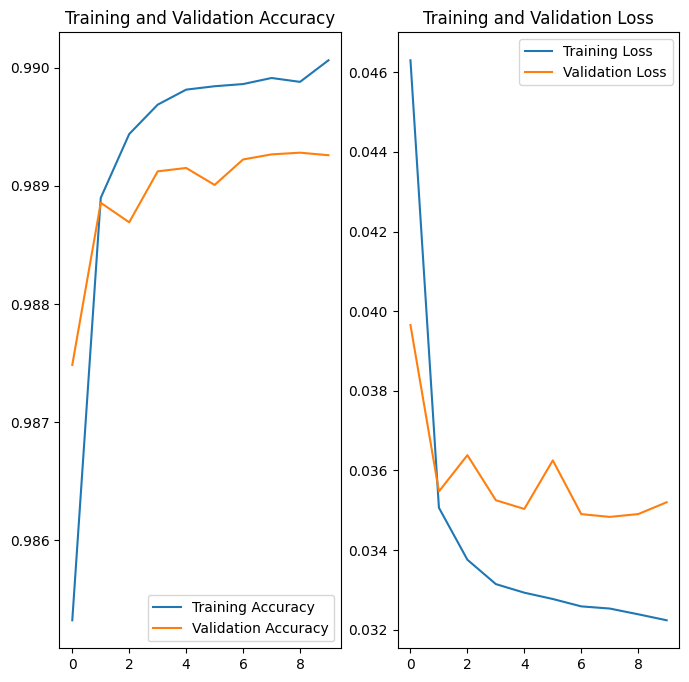

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss over epochs
acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs_range = range(len(acc))

# Accuracy plot
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

MobileNet Performance:
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step
              precision    recall  f1-score   support

       empty       0.99      0.99      0.99     35876
    occupied       0.99      0.99      0.99     33757

    accuracy                           0.99     69633
   macro avg       0.99      0.99      0.99     69633
weighted avg       0.99      0.99      0.99     69633



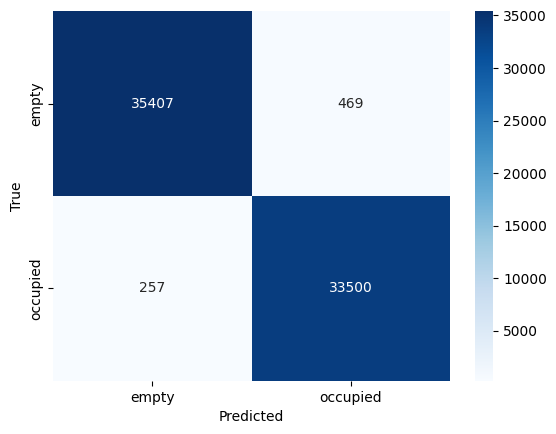

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# compute metrics
def evaluate_model(model, test_dataset):
    predictions = model.predict(test_dataset)
    predicted_labels = (predictions > 0.5).astype(int)
    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy())
    true_labels = np.array(true_labels)

    print(classification_report(true_labels, predicted_labels, target_names=['empty', 'occupied']))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['empty', 'occupied'], yticklabels=['empty', 'occupied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# evaluate MobileNet
print("MobileNet Performance:")
evaluate_model(mobilenet_model, test_dataset)